In [1]:
import json
import os

import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
from PIL import Image
from torchvision import transforms
from ultralytics import YOLO

In [3]:
# script to copy all the images to images/train folder
def copy_images_from_directory(
    source_root,
    destination_root,
    conditions=["fog", "night", "rain", "snow"],
    split="train",
):
    """
    Copy image files from source directories for different conditions to destination directories.

    Args:
    - source_root (str): The root directory containing the source image directories for different conditions.
    - destination_root (str): The root directory where the image files will be copied.
    - conditions (list of str): A list of conditions representing different subdirectories under the source_root.
    """

    for condition in conditions:
        # Destination directory where the images will be copied
        destination_directory = os.path.join(destination_root, split)

        # Source directory containing the image files
        source_directory = os.path.join(source_root, condition, split)

        for folder in os.listdir(source_directory):
            if not folder.startswith("."):
                files = os.listdir(os.path.join(source_directory, folder))
                for file in files:
                    # Check if the file is an image file (assuming all image files have the ".png" extension)
                    if file.endswith(".png"):
                        # Construct the source and destination file paths
                        source_file = os.path.join(source_directory, folder, file)
                        destination_file = os.path.join(destination_directory, file)

                        # Create the destination directory if it doesn't exist
                        os.makedirs(destination_directory, exist_ok=True)

                        # Copy the file from the source to the destination directory
                        with open(source_file, "rb") as src, open(
                            destination_file, "wb"
                        ) as dest:
                            dest.write(src.read())

        print(f"Image files copied successfully for condition: {condition}")


source_root = "/Users/parimi/Documents/TAMU/RA_Work/rgb_anon_trainvaltest/rgb_anon"
destination_root = "/Users/parimi/Documents/TAMU/RA_Work/data/images"
conditions = ["fog", "night", "rain", "snow"]

copy_images_from_directory(source_root, destination_root, conditions, "train")
copy_images_from_directory(source_root, destination_root, conditions, "val")
copy_images_from_directory(source_root, destination_root, conditions, "test")

Image files copied successfully for condition: fog
Image files copied successfully for condition: night
Image files copied successfully for condition: rain
Image files copied successfully for condition: snow
Image files copied successfully for condition: fog
Image files copied successfully for condition: night
Image files copied successfully for condition: rain
Image files copied successfully for condition: snow
Image files copied successfully for condition: fog
Image files copied successfully for condition: night
Image files copied successfully for condition: rain
Image files copied successfully for condition: snow


In [4]:
def convert_annotations_to_yolo_labels(
    json_directory,
    output_directory,
    conditions=["fog", "night", "rain", "snow"],
    split="train",
):
    """
    Convert annotations from ACDC format to YOLO format and save them as text files.

    Args:
    - json_directory (str): Path to the directory containing the JSON annotation files.
    - output_directory (str): Path to the directory where YOLO format labels will be saved.
    - conditions (list of str): List of conditions (e.g., fog, night, rain, snow) for which annotations should be processed.
    """

    # Mapping between ACDC class IDs and YOLO class IDs
    # class_conversion = {
    #     24: 0,  # person
    #     25: 7,  # rider
    #     26: 2,  # car
    #     27: 6,  # truck
    #     28: 4,  # bus
    #     31: 5,  # train
    #     32: 3,  # motorcycle
    #     33: 1,  # bicycle
    # }
    class_conversion = {
        # 24: 0,  # person
        # 25: 7,  # rider
        26: 0,  # car
        # 27: 6,  # truck
        # 28: 4,  # bus
        # 31: 5,  # train
        # 32: 3,  # motorcycle
        # 33: 1,  # bicycle
    }

    # Iterate over each condition (e.g., fog, night, rain, snow)
    for condition in conditions:
        # Load JSON data from the current file
        with open(
            f"{json_directory}/{condition}/instancesonly_{condition}_{split}_gt_detection.json",
            "r",
        ) as f:
            data = json.load(f)
        # Iterate over each image in the JSON data
        for image_info in data["images"]:
            # Extract image ID and file name
            image_id = image_info["id"]
            image_filename = image_info["file_name"]

            # Create the output directory if it doesn't exist
            output_path = os.path.join(output_directory, split)
            if not os.path.exists(output_path):
                os.makedirs(output_path)

            # Construct the output file path for YOLO labels

            output_file = os.path.join(
                output_path, f"{image_filename.split('/')[-1].split('.')[0]}.txt"
            )
            # Collect annotations for the current image ID
            image_annotations = [
                annot for annot in data["annotations"] if annot["image_id"] == image_id
            ]

            # Create directory if it doesn't exist
            output_file_dir = os.path.dirname(output_file)
            if not os.path.exists(output_file_dir):
                os.makedirs(output_file_dir)

            # Write annotations to the YOLO label file
            with open(output_file, "w") as label_file:
                for annotation in image_annotations:
                    try:
                        category_id = class_conversion[
                            annotation["category_id"]
                        ]  # converting the id
                    except: # only adding the car labels
                        continue

                    # scaling and transforming the bbox values into yolo format
                    image_height = annotation["segmentation"]["size"][0]
                    image_width = annotation["segmentation"]["size"][1]

                    bbox_transformed = annotation["bbox"]
                    bbox_transformed[0] = bbox_transformed[0] + bbox_transformed[2] / 2
                    bbox_transformed[1] = bbox_transformed[1] + bbox_transformed[3] / 2

                    bbox_scaled = bbox_transformed
                    bbox_scaled[0], bbox_scaled[2] = (
                        int(bbox_scaled[0]) / image_width,
                        int(bbox_scaled[2]) / image_width,
                    )
                    bbox_scaled[1], bbox_scaled[3] = (
                        int(bbox_scaled[1]) / image_height,
                        int(bbox_scaled[3]) / image_height,
                    )
                    bbox_values = " ".join(map(str, annotation["bbox"]))

                    # writing the values to the file
                    label_file.write(f"{category_id} {bbox_values}\n")

        print(f"Text labels created for condition: {condition}")


# Define the directory paths and conditions
json_directory = (
    "/Users/parimi/Documents/TAMU/RA_Work/gt_detection_trainval/gt_detection"
)
output_directory = "/Users/parimi/Documents/TAMU/RA_Work/data/labels"

# Convert annotations to YOLO labels
convert_annotations_to_yolo_labels(
    json_directory, output_directory, conditions, split="train"
)
convert_annotations_to_yolo_labels(
    json_directory, output_directory, conditions, split="val"
)


Text labels created for condition: fog
Text labels created for condition: night
Text labels created for condition: rain
Text labels created for condition: snow
Text labels created for condition: fog
Text labels created for condition: night
Text labels created for condition: rain
Text labels created for condition: snow


[[0.0, 0.4630208333333333, 0.725925925925926, 0.0140625, 0.022222222222222223], [0.0, 0.42291666666666666, 0.7268518518518519, 0.015104166666666667, 0.026851851851851852], [0.0, 0.4354166666666667, 0.7268518518518519, 0.014583333333333334, 0.025], [0.0, 0.49635416666666665, 0.7166666666666667, 0.016145833333333335, 0.019444444444444445], [0.0, 0.4875, 0.7222222222222222, 0.0067708333333333336, 0.011111111111111112]]


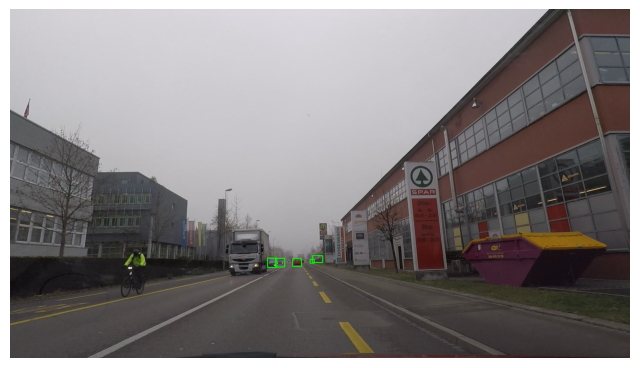

[[0.0, 0.4973958333333333, 0.7268518518518519, 0.011979166666666667, 0.016666666666666666], [0.0, 0.06041666666666667, 0.7509259259259259, 0.12083333333333333, 0.17777777777777778]]


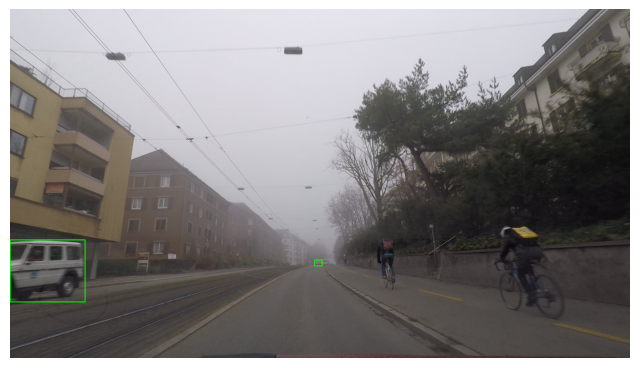

[[0.0, 0.5260416666666666, 0.7296296296296296, 0.025520833333333333, 0.03888888888888889], [0.0, 0.32760416666666664, 0.7305555555555555, 0.07760416666666667, 0.08333333333333333], [0.0, 0.08177083333333333, 0.7379629629629629, 0.16354166666666667, 0.13333333333333333]]


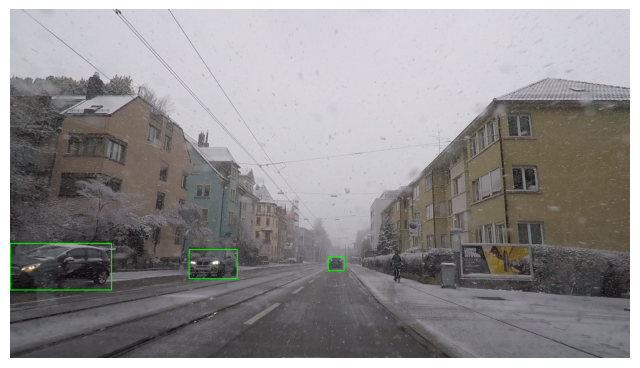

[[0.0, 0.9895833333333334, 0.6787037037037037, 0.0203125, 0.13703703703703704], [0.0, 0.4822916666666667, 0.5268518518518519, 0.03229166666666667, 0.024074074074074074], [0.0, 0.41510416666666666, 0.5287037037037037, 0.011979166666666667, 0.028703703703703703], [0.0, 0.23229166666666667, 0.524074074074074, 0.08697916666666666, 0.05648148148148148], [0.0, 0.30885416666666665, 0.5296296296296297, 0.0828125, 0.06296296296296296]]


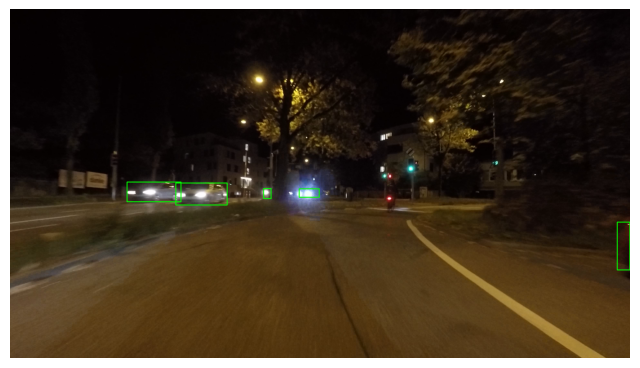

[]


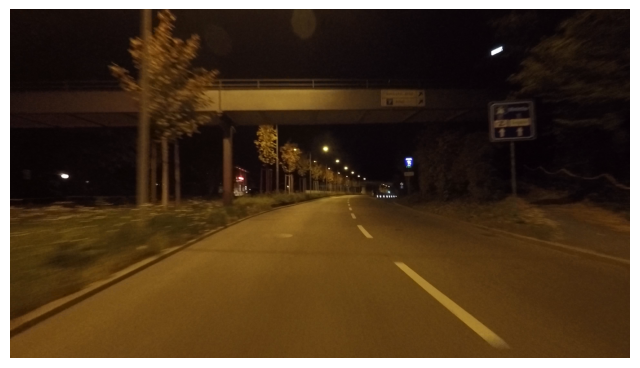

[[0.0, 0.2989583333333333, 0.5824074074074074, 0.06927083333333334, 0.04814814814814815], [0.0, 0.353125, 0.575925925925926, 0.034895833333333334, 0.04814814814814815], [0.0, 0.4427083333333333, 0.562037037037037, 0.022395833333333334, 0.025925925925925925], [0.0, 0.5239583333333333, 0.562037037037037, 0.017708333333333333, 0.027777777777777776], [0.0, 0.6901041666666666, 0.5611111111111111, 0.0578125, 0.04351851851851852], [0.0, 0.38125, 0.5685185185185185, 0.013541666666666667, 0.03333333333333333]]


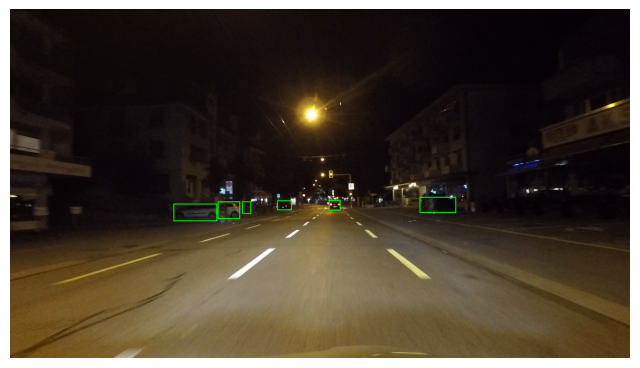

[[0.0, 0.7234375, 0.7898148148148149, 0.11510416666666666, 0.10648148148148148], [0.0, 0.5583333333333333, 0.7592592592592593, 0.0296875, 0.030555555555555555], [0.0, 0.5859375, 0.7592592592592593, 0.027604166666666666, 0.03518518518518519]]


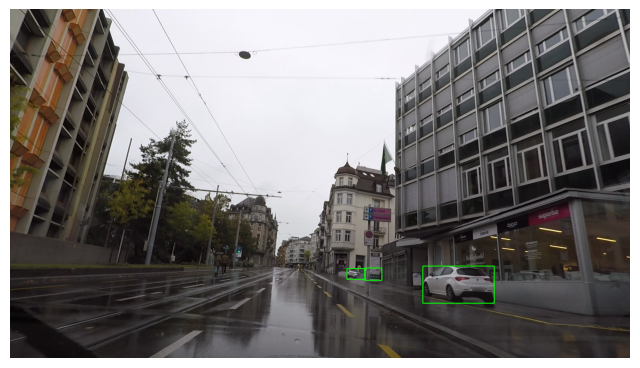

[[0.0, 0.31614583333333335, 0.7268518518518519, 0.042708333333333334, 0.030555555555555555], [0.0, 0.10625, 0.7574074074074074, 0.08489583333333334, 0.06111111111111111], [0.0, 0.2598958333333333, 0.7379629629629629, 0.0296875, 0.03796296296296296], [0.0, 0.28020833333333334, 0.7342592592592593, 0.017708333333333333, 0.03333333333333333], [0.0, 0.3489583333333333, 0.7222222222222222, 0.027083333333333334, 0.030555555555555555], [0.0, 0.22395833333333334, 0.7379629629629629, 0.04895833333333333, 0.04814814814814815]]


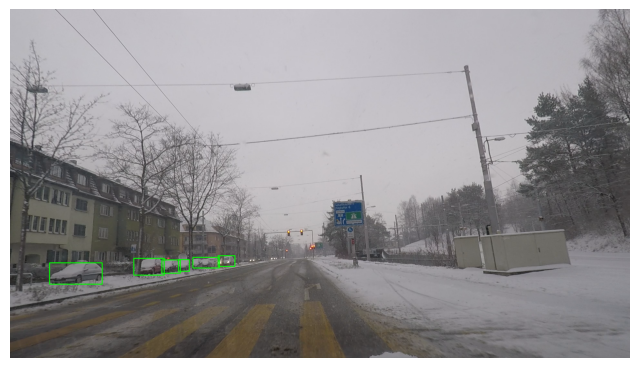

[[0.0, 0.27708333333333335, 0.7268518518518519, 0.04739583333333333, 0.02962962962962963], [0.0, 0.5036458333333333, 0.7296296296296296, 0.025, 0.04814814814814815], [0.0, 0.5067708333333333, 0.7453703703703703, 0.0203125, 0.03518518518518519], [0.0, 0.5197916666666667, 0.7472222222222222, 0.0265625, 0.03888888888888889]]


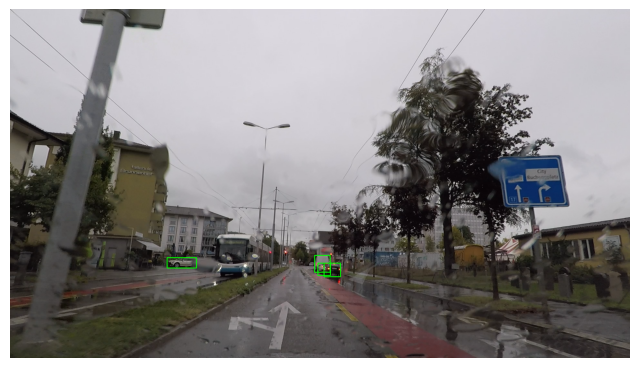

[[0.0, 0.4328125, 0.725, 0.03125, 0.04722222222222222], [0.0, 0.54375, 0.7148148148148148, 0.025520833333333333, 0.04351851851851852], [0.0, 0.6255208333333333, 0.7046296296296296, 0.044270833333333336, 0.06481481481481481], [0.0, 0.8838541666666667, 0.7157407407407408, 0.23229166666666667, 0.34444444444444444], [0.0, 0.19479166666666667, 0.7962962962962963, 0.246875, 0.2740740740740741], [0.0, 0.3385416666666667, 0.75, 0.058333333333333334, 0.10462962962962963], [0.0, 0.3770833333333333, 0.7398148148148148, 0.041666666666666664, 0.07037037037037037], [0.0, 0.396875, 0.737037037037037, 0.0203125, 0.05092592592592592], [0.0, 0.40208333333333335, 0.7268518518518519, 0.034375, 0.05740740740740741], [0.0, 0.46875, 0.7379629629629629, 0.052083333333333336, 0.07314814814814814]]


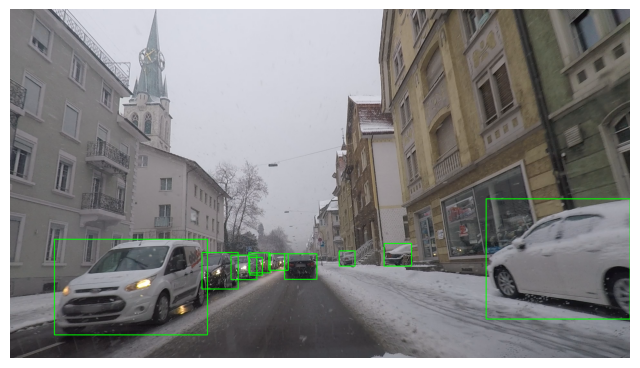

[[0.0, 0.4822916666666667, 0.725925925925926, 0.0125, 0.017592592592592594]]


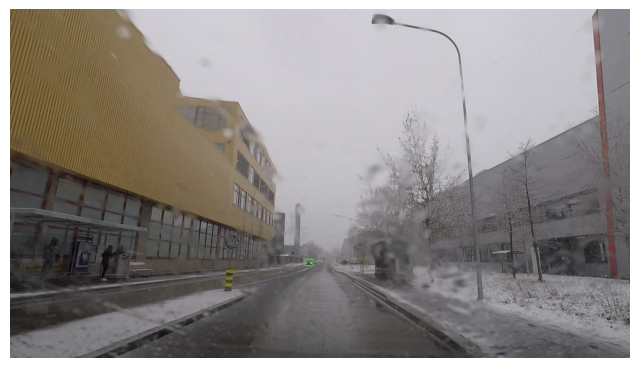

[[0.0, 0.46979166666666666, 0.725, 0.027083333333333334, 0.025], [0.0, 0.39010416666666664, 0.7453703703703703, 0.06510416666666667, 0.09074074074074075], [0.0, 0.020833333333333332, 0.7453703703703703, 0.041666666666666664, 0.22314814814814815]]


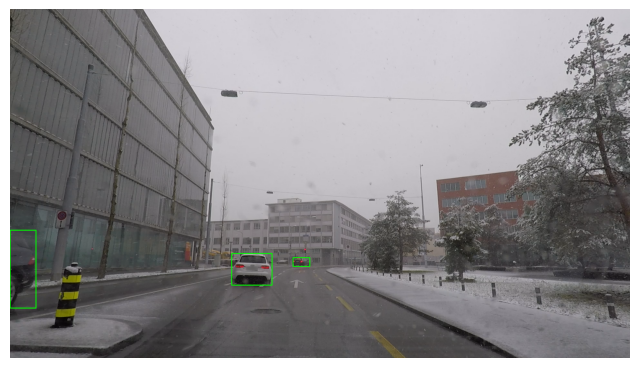

[[0.0, 0.4505208333333333, 0.725925925925926, 0.0140625, 0.021296296296296296], [0.0, 0.4817708333333333, 0.7277777777777777, 0.025520833333333333, 0.03333333333333333], [0.0, 0.5276041666666667, 0.737037037037037, 0.06041666666666667, 0.08611111111111111]]


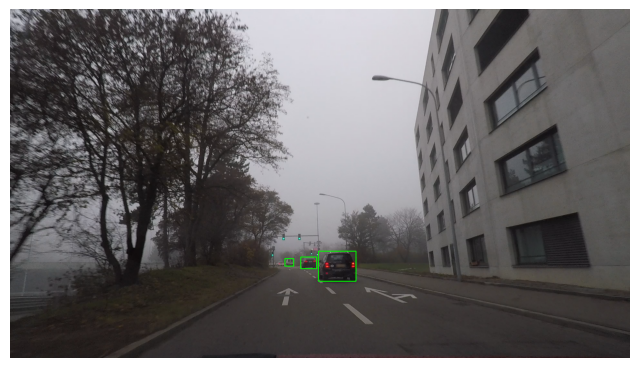

[[0.0, 0.4895833333333333, 0.7296296296296296, 0.01875, 0.025925925925925925], [0.0, 0.4557291666666667, 0.7268518518518519, 0.023958333333333335, 0.03611111111111111]]


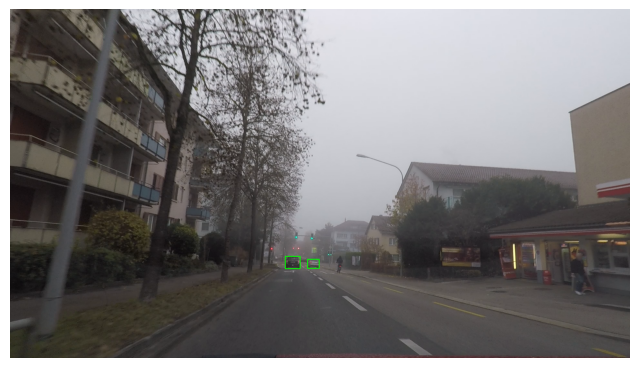

[[0.0, 0.30416666666666664, 0.7018518518518518, 0.17916666666666667, 0.17777777777777778], [0.0, 0.659375, 0.7055555555555556, 0.296875, 0.4925925925925926], [0.0, 0.9145833333333333, 0.687962962962963, 0.1046875, 0.05092592592592592], [0.0, 0.9729166666666667, 0.6842592592592592, 0.05, 0.04259259259259259]]


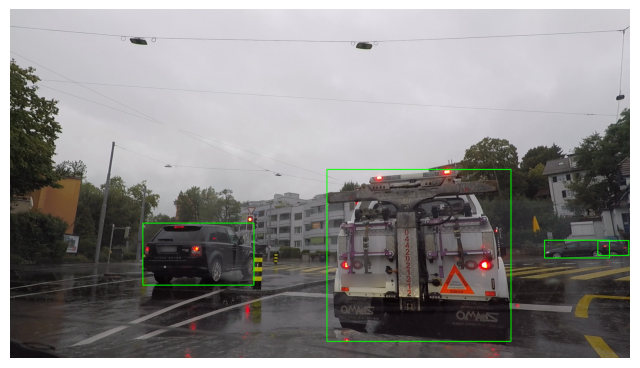

In [19]:
#script to display the image and the bounding box with labels

images = os.listdir('/Users/parimi/Documents/TAMU/RA_Work/data/images/train')

# Load PNG image using OpenCV
class_names = {
    24: 'person',
    25: 'rider',
    26: 'car',
    27: 'truck',
    28: 'bus',
    31: 'train',
    32: 'motorcycle',
    33: 'bicycle',
}

for image_path in images[10:25]:
# for i in range(0, len(image), 300):
    # image_path = image[i]
    image = cv2.imread('/Users/parimi/Documents/TAMU/RA_Work/data/images/train/'+image_path)
    # Open the file in read mode
    try:
        with open(f"/Users/parimi/Documents/TAMU/RA_Work/data/labels/train/{image_path.split('.')[0]}.txt", "r") as file:
            # Read all lines from the file into a list
            lines = file.readlines()
        # Define a list to store the integers
        bboxes = []

        # Iterate through each line and parse integers
        for line in lines:
            # Split the line into individual integer values
            # Assuming integers are separated by spaces or commas
            values = line.strip().split()  # Split the line by whitespace characters
            # Convert each value to an integer and add it to the list of integers
            box = [float(i) for i in values]
            bboxes.append(box)
        # print(bboxes)
    except FileNotFoundError:
        print('label not found')
        continue
    
    print(bboxes)
    # Draw bounding boxes on the image
    for bbox in bboxes:
        
        # class_id, x_center, y_center, width, height = map(float, line.split())
        class_id, x_center, y_center, width, height = bbox
            
        # Convert normalized coordinates to pixel coordinates
        image_height, image_width, _ = image.shape
        x_min = int((x_center - width / 2) * image_width)
        y_min = int((y_center - height / 2) * image_height)
        box_width = int(width * image_width)
        box_height = int(height * image_height)
        color = (0, 255, 0)  # Green color for the bounding boxes

        # cv2.rectangle(image, (x_min, y_min), (x_max, y_max), color, thickness)
        cv2.rectangle(image, (x_min, y_min), (x_min + box_width, y_min + box_height), color, 2)
        # print(x_min, y_min, box_width, box_height)

        # Label the bounding box with the class name
        if class_id in class_names:
            class_name = class_names[class_id]
            label = f"{class_name}"
            font = cv2.FONT_HERSHEY_SIMPLEX
            font_scale = 1
            font_thickness = 3
            text_size = cv2.getTextSize(label, font, font_scale, font_thickness)[0]
            cv2.putText(image, label, (x_min, y_min - 5), font, font_scale, color, font_thickness)

    # Convert BGR to RGB for displaying with matplotlib
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Display the image with bounding boxes using matplotlib
    plt.figure(figsize=(8, 6))
    plt.imshow(image_rgb)
    plt.axis('off')
    plt.show()

In [50]:
import os
import cv2
import matplotlib.pyplot as plt

# Define class names
class_names = {
    0: 'person',
    1: 'rider',
    2: 'car',
    3: 'truck',
    4: 'bus',
    5: 'train',
    6: 'motorcycle',
    7: 'bicycle',
}

# Define paths
images_path = '/Users/parimi/Documents/TAMU/RA_Work/data/images/train'
labels_path = '/Users/parimi/Documents/TAMU/RA_Work/data/labels/train'

# List image files
images = os.listdir(images_path)

for image_name in images[:2]:
    # Load image
    image = cv2.imread(os.path.join(images_path, image_name))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Load corresponding label file
    label_file = os.path.join(labels_path, f"{os.path.splitext(image_name)[0]}.txt")

    try:
        # Read bounding box coordinates from the label file
        with open(label_file, 'r') as f:
            lines = f.readlines()

        for line in lines:
            # Split the line and extract class ID and bounding box coordinates
            class_id, x_center, y_center, width, height = map(float, line.split())
            
            # Convert normalized coordinates to pixel coordinates
            height, width, _ = image.shape
            x_min = int((x_center - width / 2) * width)
            y_min = int((y_center - height / 2) * height)
            box_width = int(width * width)
            box_height = int(height * height)

            # Draw bounding box on the image
            cv2.rectangle(image, (x_min, y_min), (x_min + box_width, y_min + box_height), (0, 255, 0), 2)

            # Add label text
            class_name = class_names[int(class_id)]
            label = f"{class_name}"
            cv2.putText(image, label, (x_min, y_min - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

    except FileNotFoundError:
        print(f"Label file not found for {image_name}")
        continue

    # Plot the image with bounding boxes
    plt.figure(figsize=(10, 8))
    plt.imshow(image)
    plt.axis('off')
    plt.show()


/var/folders/8j/r8s_wt752_n9qp37zrrqv0lm0000gn/T/ipykernel_42848/2601962807.py:64: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


In [21]:
# Load a model
model = YOLO("yolov8n.pt")

# Use the model
results = model.train(
    data="config.yaml", epochs=15, device="mps", freeze=10
)  # train the model

Ultralytics YOLOv8.1.18 🚀 Python-3.10.13 torch-2.2.1 MPS (Apple M2 Pro)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=config.yaml, epochs=15, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=mps, workers=8, project=None, name=train10, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=10, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_width=None, fo

train: Scanning /Users/parimi/Documents/TAMU/RA_Work/data/labels/train.cache... 1600 images, 75 backgrounds, 0 corrupt: 100%|██████████| 1600/1600 [00:00<?, ?it/s]
val: Scanning /Users/parimi/Documents/TAMU/RA_Work/data/labels/val.cache... 406 images, 16 backgrounds, 0 corrupt: 100%|██████████| 406/406 [00:00<?, ?it/s]

Plotting labels to runs/detect/train10/labels.jpg... 


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs/detect/train10
Starting training for 15 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/15         0G      1.505      2.009      1.054         85        640: 100%|██████████| 100/100 [03:37<00:00,  2.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/13 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   8%|▊         | 1/13 [00:05<01:11,  5.92s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  15%|█▌        | 2/13 [00:14<01:21,  7.38s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  23%|██▎       | 3/13 [00:20<01:07,  6.71s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  31%|███       | 4/13 [00:28<01:04,  7.21s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  38%|███▊      | 5/13 [00:36<01:00,  7.60s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  46%|████▌     | 6/13 [00:44<00:53,  7.62s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  54%|█████▍    | 7/13 [00:52<00:47,  7.85s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  62%|██████▏   | 8/13 [01:00<00:40,  8.06s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  69%|██████▉   | 9/13 [01:09<00:32,  8.13s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  77%|███████▋  | 10/13 [01:17<00:24,  8.04s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  85%|████████▍ | 11/13 [01:22<00:14,  7.33s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  92%|█████████▏| 12/13 [01:31<00:07,  7.65s/it]

WARNING ⚠️ NMS time limit 3.100s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [01:36<00:00,  7.39s/it]


                   all        406       1865      0.775     0.0922      0.132     0.0831

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/15         0G      1.535      1.478      1.074        119        640: 100%|██████████| 100/100 [05:27<00:00,  3.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/13 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   8%|▊         | 1/13 [00:13<02:37, 13.12s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  15%|█▌        | 2/13 [00:25<02:21, 12.86s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  23%|██▎       | 3/13 [00:33<01:46, 10.64s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  31%|███       | 4/13 [00:46<01:41, 11.29s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  38%|███▊      | 5/13 [00:58<01:33, 11.74s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  46%|████▌     | 6/13 [01:10<01:22, 11.83s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  54%|█████▍    | 7/13 [01:20<01:06, 11.10s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  62%|██████▏   | 8/13 [01:29<00:53, 10.61s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  69%|██████▉   | 9/13 [01:40<00:42, 10.62s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  77%|███████▋  | 10/13 [01:48<00:29,  9.74s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  85%|████████▍ | 11/13 [01:55<00:18,  9.05s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  92%|█████████▏| 12/13 [02:07<00:09,  9.94s/it]

WARNING ⚠️ NMS time limit 3.100s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [02:14<00:00, 10.32s/it]


                   all        406       1865      0.393     0.0466     0.0454     0.0265

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/15         0G       1.52      1.312      1.078        108        640: 100%|██████████| 100/100 [05:34<00:00,  3.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/13 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   8%|▊         | 1/13 [00:13<02:37, 13.11s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  15%|█▌        | 2/13 [00:20<01:48,  9.84s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  23%|██▎       | 3/13 [00:25<01:17,  7.77s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  31%|███       | 4/13 [00:38<01:28,  9.85s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  38%|███▊      | 5/13 [00:47<01:13,  9.23s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  46%|████▌     | 6/13 [00:55<01:01,  8.84s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  54%|█████▍    | 7/13 [01:04<00:54,  9.09s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  62%|██████▏   | 8/13 [01:12<00:42,  8.50s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  69%|██████▉   | 9/13 [01:19<00:32,  8.09s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  77%|███████▋  | 10/13 [01:32<00:28,  9.66s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  85%|████████▍ | 11/13 [01:46<00:21, 10.91s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  92%|█████████▏| 12/13 [01:58<00:11, 11.47s/it]

WARNING ⚠️ NMS time limit 3.100s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [02:10<00:00, 10.02s/it]


                   all        406       1865       0.38     0.0429      0.045     0.0256

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/15         0G      1.465      1.164      1.059        116        640: 100%|██████████| 100/100 [09:34<00:00,  5.75s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/13 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   8%|▊         | 1/13 [00:12<02:33, 12.81s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  15%|█▌        | 2/13 [00:35<03:22, 18.38s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  23%|██▎       | 3/13 [00:56<03:19, 19.97s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  31%|███       | 4/13 [01:17<03:00, 20.05s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  38%|███▊      | 5/13 [01:34<02:33, 19.17s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  46%|████▌     | 6/13 [01:52<02:10, 18.59s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  54%|█████▍    | 7/13 [02:09<01:49, 18.32s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  62%|██████▏   | 8/13 [02:19<01:17, 15.52s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  69%|██████▉   | 9/13 [02:35<01:02, 15.56s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  77%|███████▋  | 10/13 [02:58<00:54, 18.02s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  85%|████████▍ | 11/13 [03:15<00:35, 17.63s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  92%|█████████▏| 12/13 [03:37<00:19, 19.01s/it]

WARNING ⚠️ NMS time limit 3.100s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [03:53<00:00, 17.97s/it]


                   all        406       1865      0.354     0.0456      0.043      0.025

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/15         0G      1.486      1.144      1.056        115        640: 100%|██████████| 100/100 [09:40<00:00,  5.80s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/13 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   8%|▊         | 1/13 [00:18<03:47, 18.98s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  15%|█▌        | 2/13 [00:43<04:07, 22.48s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  23%|██▎       | 3/13 [01:06<03:46, 22.61s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  31%|███       | 4/13 [01:29<03:23, 22.66s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  38%|███▊      | 5/13 [01:46<02:44, 20.56s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  46%|████▌     | 6/13 [02:09<02:30, 21.54s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  54%|█████▍    | 7/13 [02:32<02:11, 21.98s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  62%|██████▏   | 8/13 [03:30<02:47, 33.56s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  69%|██████▉   | 9/13 [03:44<01:49, 27.37s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  77%|███████▋  | 10/13 [04:00<01:10, 23.65s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  85%|████████▍ | 11/13 [04:59<01:09, 34.76s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  92%|█████████▏| 12/13 [05:13<00:28, 28.17s/it]

WARNING ⚠️ NMS time limit 3.100s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [05:21<00:00, 24.74s/it]


                   all        406       1865      0.345     0.0445     0.0478     0.0286
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/15         0G      1.476      1.135      1.063         34        640: 100%|██████████| 100/100 [17:01<00:00, 10.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/13 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   8%|▊         | 1/13 [00:15<03:07, 15.62s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  15%|█▌        | 2/13 [00:38<03:41, 20.15s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  23%|██▎       | 3/13 [00:56<03:07, 18.78s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  31%|███       | 4/13 [01:13<02:42, 18.11s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  38%|███▊      | 5/13 [01:28<02:17, 17.15s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  46%|████▌     | 6/13 [01:52<02:16, 19.52s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  54%|█████▍    | 7/13 [02:17<02:06, 21.12s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  62%|██████▏   | 8/13 [02:35<01:40, 20.15s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  69%|██████▉   | 9/13 [02:49<01:13, 18.33s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  77%|███████▋  | 10/13 [03:12<00:59, 19.72s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  85%|████████▍ | 11/13 [03:25<00:35, 17.58s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  92%|█████████▏| 12/13 [03:48<00:19, 19.25s/it]

WARNING ⚠️ NMS time limit 3.100s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [04:00<00:00, 18.52s/it]


                   all        406       1865      0.392     0.0311     0.0379     0.0234

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/15         0G      1.463      1.058      1.058         68        640: 100%|██████████| 100/100 [14:10<00:00,  8.50s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/13 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   8%|▊         | 1/13 [00:09<01:54,  9.54s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  15%|█▌        | 2/13 [00:32<03:10, 17.31s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  23%|██▎       | 3/13 [00:59<03:38, 21.85s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  31%|███       | 4/13 [01:12<02:43, 18.17s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  38%|███▊      | 5/13 [01:33<02:35, 19.49s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  46%|████▌     | 6/13 [01:46<01:59, 17.02s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  54%|█████▍    | 7/13 [02:02<01:40, 16.80s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  62%|██████▏   | 8/13 [02:17<01:20, 16.14s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  69%|██████▉   | 9/13 [02:34<01:06, 16.52s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  77%|███████▋  | 10/13 [02:47<00:46, 15.53s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  85%|████████▍ | 11/13 [03:09<00:34, 17.37s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  92%|█████████▏| 12/13 [03:27<00:17, 17.46s/it]

WARNING ⚠️ NMS time limit 3.100s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [03:39<00:00, 16.88s/it]


                   all        406       1865      0.253     0.0172      0.025     0.0159

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/15         0G      1.422      1.023       1.04         63        640: 100%|██████████| 100/100 [20:08<00:00, 12.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/13 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   8%|▊         | 1/13 [00:06<01:23,  6.97s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  15%|█▌        | 2/13 [00:18<01:46,  9.71s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  23%|██▎       | 3/13 [00:31<01:50, 11.07s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  31%|███       | 4/13 [01:03<02:52, 19.22s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  38%|███▊      | 5/13 [01:16<02:17, 17.17s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  46%|████▌     | 6/13 [01:30<01:52, 16.04s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  54%|█████▍    | 7/13 [01:43<01:29, 14.96s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  62%|██████▏   | 8/13 [01:57<01:13, 14.73s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  69%|██████▉   | 9/13 [02:10<00:57, 14.25s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  77%|███████▋  | 10/13 [02:31<00:48, 16.30s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  85%|████████▍ | 11/13 [02:41<00:28, 14.34s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  92%|█████████▏| 12/13 [02:59<00:15, 15.51s/it]

WARNING ⚠️ NMS time limit 3.100s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [03:15<00:00, 15.06s/it]


                   all        406       1865       0.29     0.0231     0.0323     0.0203

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/15         0G      1.387     0.9842       1.03         49        640: 100%|██████████| 100/100 [12:14<00:00,  7.35s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/13 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   8%|▊         | 1/13 [00:14<02:55, 14.67s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  15%|█▌        | 2/13 [00:28<02:36, 14.19s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  23%|██▎       | 3/13 [00:49<02:52, 17.29s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  31%|███       | 4/13 [01:13<02:59, 19.94s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  38%|███▊      | 5/13 [01:41<03:03, 22.92s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  46%|████▌     | 6/13 [02:06<02:45, 23.58s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  54%|█████▍    | 7/13 [02:25<02:11, 21.96s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  62%|██████▏   | 8/13 [02:44<01:44, 20.99s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  69%|██████▉   | 9/13 [02:57<01:15, 18.77s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  77%|███████▋  | 10/13 [03:26<01:05, 21.74s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  85%|████████▍ | 11/13 [03:39<00:38, 19.11s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  92%|█████████▏| 12/13 [03:48<00:15, 15.92s/it]

WARNING ⚠️ NMS time limit 3.100s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [04:05<00:00, 18.86s/it]


                   all        406       1865      0.316     0.0273     0.0401     0.0227

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/15         0G      1.355     0.9553      1.024         70        640: 100%|██████████| 100/100 [12:52<00:00,  7.73s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/13 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   8%|▊         | 1/13 [00:08<01:44,  8.73s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  15%|█▌        | 2/13 [00:25<02:30, 13.64s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  23%|██▎       | 3/13 [00:49<03:01, 18.19s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  31%|███       | 4/13 [00:56<02:05, 13.99s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  38%|███▊      | 5/13 [01:54<03:57, 29.70s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  46%|████▌     | 6/13 [02:10<02:55, 25.03s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  54%|█████▍    | 7/13 [02:21<02:03, 20.59s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  62%|██████▏   | 8/13 [02:40<01:39, 19.92s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  69%|██████▉   | 9/13 [02:54<01:11, 17.94s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  77%|███████▋  | 10/13 [03:19<01:00, 20.22s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  85%|████████▍ | 11/13 [03:33<00:36, 18.37s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  92%|█████████▏| 12/13 [04:01<00:21, 21.34s/it]

WARNING ⚠️ NMS time limit 3.100s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [04:28<00:00, 20.69s/it]


                   all        406       1865      0.419     0.0311     0.0418     0.0235

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/15         0G      1.352     0.9315      1.016         60        640: 100%|██████████| 100/100 [13:33<00:00,  8.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/13 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   8%|▊         | 1/13 [00:23<04:43, 23.60s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  15%|█▌        | 2/13 [00:37<03:14, 17.70s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  23%|██▎       | 3/13 [00:53<02:48, 16.86s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  31%|███       | 4/13 [01:16<02:56, 19.59s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  38%|███▊      | 5/13 [01:25<02:05, 15.72s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  46%|████▌     | 6/13 [01:48<02:06, 18.14s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  54%|█████▍    | 7/13 [02:05<01:46, 17.81s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  62%|██████▏   | 8/13 [02:16<01:18, 15.72s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  69%|██████▉   | 9/13 [02:35<01:06, 16.61s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  77%|███████▋  | 10/13 [02:58<00:56, 18.71s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  85%|████████▍ | 11/13 [03:20<00:39, 19.51s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  92%|█████████▏| 12/13 [03:31<00:17, 17.05s/it]

WARNING ⚠️ NMS time limit 3.100s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [03:49<00:00, 17.64s/it]


                   all        406       1865      0.377     0.0214     0.0378     0.0242

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/15         0G      1.328     0.9203       1.01         66        640: 100%|██████████| 100/100 [13:10<00:00,  7.91s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/13 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   8%|▊         | 1/13 [00:07<01:35,  7.95s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  15%|█▌        | 2/13 [00:33<03:23, 18.49s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  23%|██▎       | 3/13 [00:41<02:17, 13.75s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  31%|███       | 4/13 [00:54<02:00, 13.42s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  38%|███▊      | 5/13 [01:21<02:25, 18.18s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  46%|████▌     | 6/13 [01:59<02:55, 25.06s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  54%|█████▍    | 7/13 [02:19<02:20, 23.40s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  62%|██████▏   | 8/13 [02:38<01:49, 21.84s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  69%|██████▉   | 9/13 [02:47<01:11, 17.88s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  77%|███████▋  | 10/13 [03:01<00:50, 16.77s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  85%|████████▍ | 11/13 [03:26<00:38, 19.24s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  92%|█████████▏| 12/13 [03:55<00:22, 22.20s/it]

WARNING ⚠️ NMS time limit 3.100s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [04:11<00:00, 19.37s/it]


                   all        406       1865      0.343     0.0322     0.0461     0.0287

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/15         0G      1.296     0.8821     0.9973         64        640: 100%|██████████| 100/100 [14:17<00:00,  8.58s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/13 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   8%|▊         | 1/13 [00:18<03:47, 18.95s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  15%|█▌        | 2/13 [00:48<04:36, 25.11s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  23%|██▎       | 3/13 [01:16<04:25, 26.59s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  31%|███       | 4/13 [01:25<02:54, 19.43s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  38%|███▊      | 5/13 [01:40<02:22, 17.82s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  46%|████▌     | 6/13 [01:52<01:52, 16.05s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  54%|█████▍    | 7/13 [02:07<01:33, 15.54s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  62%|██████▏   | 8/13 [02:19<01:12, 14.46s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  69%|██████▉   | 9/13 [02:27<00:50, 12.58s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  77%|███████▋  | 10/13 [02:40<00:37, 12.46s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  85%|████████▍ | 11/13 [03:03<00:31, 15.93s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  92%|█████████▏| 12/13 [03:32<00:19, 19.78s/it]

WARNING ⚠️ NMS time limit 3.100s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [03:40<00:00, 16.94s/it]


                   all        406       1865      0.331       0.03     0.0434     0.0273

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/15         0G      1.284     0.8684     0.9892         68        640: 100%|██████████| 100/100 [12:51<00:00,  7.71s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/13 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   8%|▊         | 1/13 [00:26<05:13, 26.12s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  15%|█▌        | 2/13 [00:53<04:54, 26.75s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  23%|██▎       | 3/13 [01:19<04:24, 26.45s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  31%|███       | 4/13 [01:28<02:57, 19.75s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  38%|███▊      | 5/13 [01:38<02:08, 16.10s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  46%|████▌     | 6/13 [01:57<01:59, 17.09s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  54%|█████▍    | 7/13 [02:12<01:38, 16.43s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  62%|██████▏   | 8/13 [02:35<01:32, 18.51s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  69%|██████▉   | 9/13 [02:50<01:09, 17.39s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  77%|███████▋  | 10/13 [03:02<00:47, 15.68s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  85%|████████▍ | 11/13 [03:28<00:37, 18.92s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  92%|█████████▏| 12/13 [03:40<00:16, 16.71s/it]

WARNING ⚠️ NMS time limit 3.100s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [04:00<00:00, 18.52s/it]


                   all        406       1865      0.385     0.0306     0.0511     0.0342

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/15         0G      1.262     0.8523     0.9801         69        640: 100%|██████████| 100/100 [12:59<00:00,  7.79s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/13 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   8%|▊         | 1/13 [00:07<01:33,  7.78s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  15%|█▌        | 2/13 [00:34<03:27, 18.84s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  23%|██▎       | 3/13 [00:46<02:39, 15.90s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  31%|███       | 4/13 [00:58<02:08, 14.24s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  38%|███▊      | 5/13 [01:32<02:50, 21.27s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  46%|████▌     | 6/13 [01:48<02:16, 19.56s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  54%|█████▍    | 7/13 [02:01<01:44, 17.41s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  62%|██████▏   | 8/13 [02:40<02:01, 24.22s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  69%|██████▉   | 9/13 [02:52<01:21, 20.49s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  77%|███████▋  | 10/13 [03:21<01:08, 22.99s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  85%|████████▍ | 11/13 [03:40<00:43, 21.76s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  92%|█████████▏| 12/13 [03:53<00:19, 19.14s/it]

WARNING ⚠️ NMS time limit 3.100s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [04:01<00:00, 18.60s/it]


                   all        406       1865      0.493      0.029     0.0423     0.0277

15 epochs completed in 3.869 hours.
Optimizer stripped from runs/detect/train10/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train10/weights/best.pt, 6.2MB

Validating runs/detect/train10/weights/best.pt...
Ultralytics YOLOv8.1.18 🚀 Python-3.10.13 torch-2.2.1 MPS (Apple M2 Pro)
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/13 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   8%|▊         | 1/13 [00:06<01:12,  6.05s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  15%|█▌        | 2/13 [00:12<01:08,  6.23s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  23%|██▎       | 3/13 [00:19<01:05,  6.54s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  31%|███       | 4/13 [00:26<00:59,  6.64s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  38%|███▊      | 5/13 [00:32<00:53,  6.66s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  46%|████▌     | 6/13 [00:39<00:46,  6.62s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  54%|█████▍    | 7/13 [00:45<00:39,  6.60s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  62%|██████▏   | 8/13 [00:52<00:32,  6.50s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  69%|██████▉   | 9/13 [00:58<00:26,  6.58s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  77%|███████▋  | 10/13 [01:05<00:19,  6.58s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  85%|████████▍ | 11/13 [01:12<00:13,  6.58s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  92%|█████████▏| 12/13 [01:18<00:06,  6.66s/it]

WARNING ⚠️ NMS time limit 3.100s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [01:25<00:00,  6.54s/it]


                   all        406       1865      0.771     0.0217     0.0305     0.0193
Speed: 1.3ms preprocess, 12.4ms inference, 0.0ms loss, 155.2ms postprocess per image
Results saved to runs/detect/train10


In [22]:
# Load a model
model = YOLO("yolov8n.pt")

# Use the model
results = model.train(data="config.yaml", epochs=7, freeze=10)  # train the model

New https://pypi.org/project/ultralytics/8.1.19 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.1.18 🚀 Python-3.10.13 torch-2.2.1 CPU (Apple M2 Pro)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=config.yaml, epochs=7, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train11, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=10, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, sav

train: Scanning /Users/parimi/Documents/TAMU/RA_Work/data/labels/train.cache... 1600 images, 75 backgrounds, 0 corrupt: 100%|██████████| 1600/1600 [00:00<?, ?it/s]
val: Scanning /Users/parimi/Documents/TAMU/RA_Work/data/labels/val.cache... 406 images, 16 backgrounds, 0 corrupt: 100%|██████████| 406/406 [00:00<?, ?it/s]

Plotting labels to runs/detect/train11/labels.jpg... 


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs/detect/train11
Starting training for 7 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/7         0G      1.504      2.009      1.054         85        640: 100%|██████████| 100/100 [08:21<00:00,  5.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:55<00:00,  4.29s/it]

                   all        406       1865      0.841       0.29      0.426       0.26



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/7         0G      1.531      1.468      1.072        119        640: 100%|██████████| 100/100 [08:27<00:00,  5.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:55<00:00,  4.30s/it]

                   all        406       1865       0.65       0.48      0.535      0.321

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



        3/7         0G        1.5      1.296      1.063        108        640: 100%|██████████| 100/100 [08:24<00:00,  5.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:54<00:00,  4.22s/it]

                   all        406       1865      0.701       0.51      0.572      0.325

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



        4/7         0G      1.432      1.155      1.045        116        640: 100%|██████████| 100/100 [08:47<00:00,  5.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:56<00:00,  4.38s/it]

                   all        406       1865      0.694      0.522      0.578      0.345

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



        5/7         0G      1.434      1.111       1.04        115        640: 100%|██████████| 100/100 [08:39<00:00,  5.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:56<00:00,  4.34s/it]

                   all        406       1865      0.761      0.512      0.598      0.348



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        6/7         0G      1.395      1.043      1.026        116        640: 100%|██████████| 100/100 [08:27<00:00,  5.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:55<00:00,  4.23s/it]

                   all        406       1865      0.744      0.532       0.61      0.365

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



        7/7         0G      1.366      1.004      1.015        112        640: 100%|██████████| 100/100 [08:21<00:00,  5.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:55<00:00,  4.24s/it]

                   all        406       1865      0.768      0.532      0.615      0.374

7 epochs completed in 1.101 hours.
Optimizer stripped from runs/detect/train11/weights/last.pt, 6.2MB


Optimizer stripped from runs/detect/train11/weights/best.pt, 6.2MB

Validating runs/detect/train11/weights/best.pt...
Ultralytics YOLOv8.1.18 🚀 Python-3.10.13 torch-2.2.1 CPU (Apple M2 Pro)
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:53<00:00,  4.09s/it]


                   all        406       1865      0.769      0.533      0.615      0.374
Speed: 0.4ms preprocess, 102.0ms inference, 0.0ms loss, 0.2ms postprocess per image
Results saved to runs/detect/train11


In [2]:
best_model = YOLO("/Users/parimi/Documents/TAMU/RA_Work/runs/detect/train11/weights/last.pt")
cap = cv2.VideoCapture("/Users/parimi/Documents/TAMU/RA_Work/snow_driving.mp4")
while True:
    ret, frame = cap.read()
    if not ret:
        break
    results = best_model(frame)
    result = results[0]
    bboxes = np.array(result.boxes.xyxy.cpu(), dtype='int')
    for bbox in bboxes:
        (x, y, x2, y2) = bbox
        cv2.rectangle(frame, (x, y), (x2, y2), (0,0,225), 2)
    cv2.imshow("Img", frame)
    key = cv2.waitKey(1)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()




0: 384x640 2 cars, 41.0ms
Speed: 2.1ms preprocess, 41.0ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 cars, 39.9ms
Speed: 1.1ms preprocess, 39.9ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 cars, 36.7ms
Speed: 1.0ms preprocess, 36.7ms inference, 0.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 cars, 37.3ms
Speed: 1.0ms preprocess, 37.3ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 cars, 55.7ms
Speed: 1.2ms preprocess, 55.7ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 cars, 48.8ms
Speed: 1.2ms preprocess, 48.8ms inference, 0.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 cars, 53.0ms
Speed: 1.2ms preprocess, 53.0ms inference, 0.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 cars, 49.2ms
Speed: 1.0ms preprocess, 49.2ms inference, 0.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x